In [1]:
import time
from options.train_options import TrainOptions
from data import CustomDataset
from models import create_model
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import os
from util import util
import numpy as np
import torch
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
from skimage import data, io

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
def calculateMean(vars):
    return sum(vars) / len(vars)

def save_img(path, img):
    fold, name = os.path.split(path)
    os.makedirs(fold, exist_ok=True)
    io.imsave(path, img)

def resolveResults(results):
    interval_metrics = {}
    mask, mse, psnr, fmse, ssim = np.array(results['mask']), np.array(results['mse']), np.array(results['psnr']), np.array(results['fmse']), np.array(results['ssim'])
    interval_metrics['0.00-0.05'] = [np.mean(mse[np.logical_and(mask <= 0.05, mask > 0.0)]),
                                    np.mean(psnr[np.logical_and(mask <= 0.05, mask > 0.0)]),
                                    np.mean(fmse[np.logical_and(mask <= 0.05, mask > 0.0)]),
                                    np.mean(ssim[np.logical_and(mask <= 0.05, mask > 0.0)])]

    interval_metrics['0.05-0.15'] = [np.mean(mse[np.logical_and(mask <= 0.15, mask > 0.05)]),
                                    np.mean(psnr[np.logical_and(mask <= 0.15, mask > 0.05)]),
                                    np.mean(fmse[np.logical_and(mask <= 0.15, mask > 0.05)]),
                                    np.mean(ssim[np.logical_and(mask <= 0.15, mask > 0.05)])]

    interval_metrics['0.15-1.00'] = [np.mean(mse[mask > 0.15]),
                                    np.mean(psnr[mask > 0.15]),
                                    np.mean(fmse[mask > 0.15]),
                                    np.mean(ssim[mask > 0.15])]

    print(interval_metrics)
    return interval_metrics

def updateWriterInterval(writer, metrics, epoch):
    for k, v in metrics.items():
        writer.add_scalar('interval/{}-MSE'.format(k), v[0], epoch)
        writer.add_scalar('interval/{}-PSNR'.format(k), v[1], epoch)

In [12]:
# setup_seed(6)
list_args = ["--dataset_root", "datasets/HAdobe5k", "--checkpoints_dir", "results_0701", "--name", "eval", "--batch_size", "12", "--is_train", 0]
opt = TrainOptions().parse(args=list_args)   # get training 

test_dataset = CustomDataset(opt, is_for_train=False)
test_dataset_size = len(test_dataset)
print('The number of testing images = %d' % test_dataset_size)

test_dataloader = test_dataset.load_data()
print('The total batches of training images = %d' % len(test_dataset.dataloader))

loading test file...
dataset [Iharmony4Dataset] was created
The number of testing images = 2160
The total batches of training images = 180


In [4]:
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)               # regular setup: load and print networks; create schedulers
model.netG.eval()
# total_iters = 0                # the total number of training iterations
# writer = SummaryWriter(os.path.join(opt.checkpoints_dir, opt.name))

# evaluate for every epoch
epoch = 0
max_psnr=0
# epoch_mse, epoch_psnr, epoch_interval_metrics = evaluateModel(epoch, model, opt, test_dataloader, 'eval', max_psnr)
# def evaluateModel(epoch_number, model, opt, test_dataset, epoch, max_psnr, iters=None):
epoch_number = epoch
iters = None

initialize network with normal
model [HDNetModel] was created
ckpt: latest
loading the model from results_0701/eval/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 10.414 M
-----------------------------------------------


In [5]:
total_eval_results = {'mask': [], 'mse': [], 'psnr': [], 'fmse':[], 'ssim':[]}

In [13]:
# if iters is not None:
#     eval_path = os.path.join(opt.checkpoints_dir, opt.name, 'Eval_%s_iter%d.csv' % (epoch, iters))  # define the website directory
# else:
#     eval_path = os.path.join(opt.checkpoints_dir, opt.name, 'Eval_%s.csv' % (epoch))  # define the website directory
eval_results_path = os.path.join('evaluate','results0712')
util.mkdir(eval_results_path)
csv_eval = os.path.join(eval_results_path, 'eval_39.csv')
flag_exists = os.path.exists(csv_eval)
eval_results_fstr = open(csv_eval, 'a')
if not flag_exists:
    eval_results_fstr.writelines('img_path,mask_ratio,mse,psnr,fmse,ssim\n') 

eval_results = {'mask': [], 'mse': [], 'psnr': [], 'fmse':[], 'ssim':[]}

for i, data in tqdm(enumerate(test_dataloader)):
    model.set_input(data)  # unpack data from data loader
    model.test()  # inference
    visuals = model.get_current_visuals()  # get image results
    output = visuals['attentioned']
    real = visuals['real']
    inputs = visuals['comp']
    masks = visuals['mask']

    for i_img in range(real.size(0)):
        gt, pred = real[i_img:i_img+1], output[i_img:i_img+1]
        fore_nums = data['mask'][i_img].sum().item()
        comp = inputs[i_img:i_img+1]
        mask = masks[i_img:i_img+1]
        img_comp = util.tensor2im(comp)
        img_pred = util.tensor2im(pred)
        img_gt = util.tensor2im(gt)
        img_mask = util.tensor2im(mask)

        mse_score_op = mean_squared_error(img_pred,img_gt )
        psnr_score_op = peak_signal_noise_ratio(img_pred, img_gt, data_range=255)
        fmse_score_op = mean_squared_error(img_pred, img_gt) * 256 * 256 / fore_nums
        ssim_score = ssim(img_pred[...,0], img_gt[...,0],data_range=255, multichannel=False)

        img_save = np.concatenate([img_comp, img_mask, img_pred, img_gt],axis=1)
        img_path = data['img_path'][i_img]
        basename, imagename = os.path.split(img_path)
        basename = basename.split('/')[-2]
        save_img(os.path.join(eval_results_path, basename, imagename.split('.')[0] + '.png'), img_save)

        # update calculator
        eval_results['mse'].append(mse_score_op)
        eval_results['psnr'].append(psnr_score_op)
        eval_results['fmse'].append(fmse_score_op)         
        eval_results['ssim'].append(ssim_score) 
        eval_results['mask'].append(data['mask'][i_img].mean().item())
        # eval_results_fstr.writelines('%s,%.3f,%.3f,%.3f\n' % (data['img_path'][i_img], eval_results['mask'][-1],mse_score_op, psnr_score_op))
        eval_results_fstr.writelines('%s,%.3f,%.3f,%.3f,%.3f,%.3f\n' % (
                data['img_path'][i_img], 
                eval_results['mask'][-1], 
                mse_score_op, 
                psnr_score_op, 
                fmse_score_op, 
                ssim_score))
    if i + 1 % 100 == 0:
        # print('%d images have been processed' % (i + 1))
        eval_results_fstr.flush()
total_eval_results['mse']+=eval_results['mse']
total_eval_results['psnr']+=eval_results['psnr']
total_eval_results['fmse']+=eval_results['fmse']
total_eval_results['ssim']+=eval_results['ssim']
total_eval_results['mask']+=eval_results['mask']
eval_results_fstr.flush()

all_mask_ratio = calculateMean(eval_results['mask'])
all_mse = calculateMean(eval_results['mse'])
all_psnr = calculateMean(eval_results['psnr'])
all_fmse = calculateMean(eval_results['fmse'])
all_ssim = calculateMean(eval_results['ssim'])

eval_results_fstr.writelines('%s,%.3f,%.3f,%.3f,%.3f,%.3f\n' % (
    opt.dataset_root.split('/')[-1], 
    all_mask_ratio, 
    all_mse, 
    all_psnr, 
    all_fmse, 
    all_ssim))
eval_results_fstr.flush()
res = resolveResults(eval_results)
for key in res.keys():
    eval_results_fstr.writelines('%s,%s,%.3f,%.3f,%.3f,%.3f\n' % (
        opt.dataset_root.split('/')[-1]+'_ratio', 
        key, 
        res[key][0], 
        res[key][1],
        res[key][2],
        res[key][3]))
eval_results_fstr.flush()
print('MSE:%.3f, PSNR:%.3f, fMSE:%.3f, SSIM:%.3f' % (all_mse, all_psnr, all_fmse, all_ssim))

180it [06:12,  2.07s/it]

{'0.00-0.05': [2.896916275190631, 45.752317984238665, 125.12995445077921, 0.9981732634650321], '0.05-0.15': [10.028122024727345, 39.895339153075696, 109.66277218128157, 0.9940308336181948], '0.15-1.00': [35.450137997979986, 35.32049401057371, 102.92213008336115, 0.9827571315657808]}
MSE:16.094, PSNR:40.424, fMSE:112.863, SSIM:0.992


In [14]:
all_mask_ratio = calculateMean(total_eval_results['mask'])
all_mse = calculateMean(total_eval_results['mse'])
all_psnr = calculateMean(total_eval_results['psnr'])
all_fmse = calculateMean(total_eval_results['fmse'])
all_ssim = calculateMean(total_eval_results['ssim'])

eval_results_fstr.writelines('%s,%.3f,%.3f,%.3f,%.3f,%.3f\n' % (
    'total', 
    all_mask_ratio, 
    all_mse, 
    all_psnr, 
    all_fmse, 
    all_ssim))
eval_results_fstr.flush()
res = resolveResults(total_eval_results)
for key in res.keys():
    eval_results_fstr.writelines('%s,%s,%.3f,%.3f,%.3f,%.3f\n' % (
        'total_ratio', 
        key, 
        res[key][0], 
        res[key][1],
        res[key][2],
        res[key][3]))
eval_results_fstr.flush()
eval_results_fstr.close()
print('MSE:%.3f, PSNR:%.3f, fMSE:%.3f, SSIM:%.3f' % (all_mse, all_psnr, all_fmse, all_ssim))

{'0.00-0.05': [4.7301684628668585, 43.40275285764228, 217.77594458114675, 0.9981364613730324], '0.05-0.15': [15.474802327119406, 38.20165666152765, 179.0575111897921, 0.9934731219583088], '0.15-1.00': [56.68490461955407, 33.34803406823775, 183.64174159436016, 0.9796508464098572]}
MSE:18.915, PSNR:39.835, fMSE:200.114, SSIM:0.993


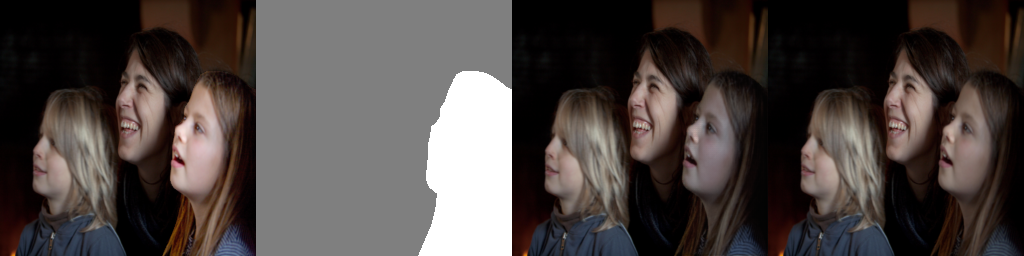

In [15]:
Image.fromarray(img_save)